In [1]:
import os
import sys
import re
import time
import math
from datetime import timedelta
from datetime import timezone
from datetime import datetime
import json

# Third Party
import pandas as pd
import numpy as np
import requests

# FINANCE
import yfinance as yf
import ccxt
from openbb_terminal.sdk import openbb

# CHARTS
import ta
from ta.trend import IchimokuIndicator
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
from ta.volume import VolumeWeightedAveragePrice
# PLOT
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set_theme()

Portfolio Optimization Toolkit is disabled. To use the Optimization features please install the toolkit following the instructions here: https://my.openbb.co/app/sdk/installation

In [2]:

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
API_GLASSNODE_KEY = os.getenv("API_GLASSNODE_KEY")
openbb.keys.glassnode(key=os.getenv("API_GLASSNODE_KEY"))
openbb.keys.messari(key=os.getenv("API_MESSARI_KEY"))

# unemployment
path_unemployment = "data/unemployment_usa.csv"
# federal funds rate
path_rate = "data/FEDFUNDS.csv"
# inflation
path_inflation = "data/inflation_usa.csv"


In [3]:
# load local data
# load unemployment
df_unemployment = pd.read_csv(path_unemployment)
# load federal funds rate
df_rate = pd.read_csv(path_rate)
# load inflation
df_inflation = pd.read_csv(path_inflation)

In [4]:
df_unemployment

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7
...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9


In [5]:
# check unemployment nan into df_unemployment 
# assert that nothing is nan
assert df_unemployment.isna().sum().sum() == 0

In [6]:
df_unemployment.isna()

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
236,False,False,False,False,False,False,False,False,False
237,False,False,False,False,False,False,False,False,False
238,False,False,False,False,False,False,False,False,False
239,False,False,False,False,False,False,False,False,False


In [7]:
df_inflation

,Mois/Année,Taux d’inflation (%)
0,Juil 2004,3.0
1,Août 2004,2.7
2,Sep 2004,2.5
3,Oct 2004,3.2
4,Nov 2004,3.5
...,...,...
236,Mar 2024,3.5
237,Avr 2024,3.4
238,Mai 2024,3.3
239,Juin 2024,3.0


In [8]:
df_inflation.columns[1]

'Taux d’inflation (%)'

In [9]:
df = df_unemployment.copy()
# add inflation
df["Inflation"] = df_inflation["Taux d’inflation (%)"]
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5
...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0


In [10]:
# find Nan value in inflation
assert  df[df["Inflation"].isna()].shape[0]==0

In [11]:
df_rate

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33
840,2024-07-01,5.33


In [12]:
df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]

,DATE,FEDFUNDS
600,2004-07-01,1.26
601,2004-08-01,1.43
602,2004-09-01,1.61
603,2004-10-01,1.76
604,2004-11-01,1.93
...,...,...
836,2024-03-01,5.33
837,2024-04-01,5.33
838,2024-05-01,5.33
839,2024-06-01,5.33


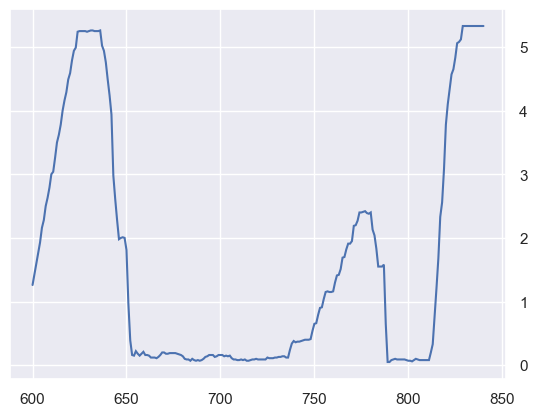

In [13]:
plt.plot(df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"])

In [14]:
df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values

array([1.26, 1.43, 1.61, 1.76, 1.93, 2.16, 2.28, 2.5 , 2.63, 2.79, 3.  ,
       3.04, 3.26, 3.5 , 3.62, 3.78, 4.  , 4.16, 4.29, 4.49, 4.59, 4.79,
       4.94, 4.99, 5.24, 5.25, 5.25, 5.25, 5.25, 5.24, 5.25, 5.26, 5.26,
       5.25, 5.25, 5.25, 5.26, 5.02, 4.94, 4.76, 4.49, 4.24, 3.94, 2.98,
       2.61, 2.28, 1.98, 2.  , 2.01, 2.  , 1.81, 0.97, 0.39, 0.16, 0.15,
       0.22, 0.18, 0.15, 0.18, 0.21, 0.16, 0.16, 0.15, 0.12, 0.12, 0.12,
       0.11, 0.13, 0.16, 0.2 , 0.2 , 0.18, 0.18, 0.19, 0.19, 0.19, 0.19,
       0.18, 0.17, 0.16, 0.14, 0.1 , 0.09, 0.09, 0.07, 0.1 , 0.08, 0.07,
       0.08, 0.07, 0.08, 0.1 , 0.13, 0.14, 0.16, 0.16, 0.16, 0.13, 0.14,
       0.16, 0.16, 0.16, 0.14, 0.15, 0.14, 0.15, 0.11, 0.09, 0.09, 0.08,
       0.08, 0.09, 0.08, 0.09, 0.07, 0.07, 0.08, 0.09, 0.09, 0.1 , 0.09,
       0.09, 0.09, 0.09, 0.09, 0.12, 0.11, 0.11, 0.11, 0.12, 0.12, 0.13,
       0.13, 0.14, 0.14, 0.12, 0.12, 0.24, 0.34, 0.38, 0.36, 0.37, 0.37,
       0.38, 0.39, 0.4 , 0.4 , 0.4 , 0.41, 0.54, 0.

In [15]:
# add funds rate to df
df["FEDFUNDS"] = df_rate[(df_rate["DATE"] >= "2004-07-01") & (df_rate["DATE"] <= "2024-07-01")]["FEDFUNDS"].values
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93
...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33


In [16]:
# check if nan into FEDFUNDS
assert df[df["FEDFUNDS"].isna()].shape[0] == 0

In [17]:
# add do Df the indice SPX from yahoo finance ? 
# add the indice SPX from yahoo finance
df_spx = yf.Ticker("^GSPC").history(
    start="2003-07-01", end="2024-08-01", interval="1mo")



In [18]:
df_spx

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-07-01 00:00:00-04:00,974.500000,1015.409973,962.099976,990.309998,31553200000,0.0,0.0
2003-08-01 00:00:00-04:00,990.309998,1011.010010,960.840027,1008.010010,24881470000,0.0,0.0
2003-09-01 00:00:00-04:00,1008.010010,1040.290039,990.359985,995.969971,29940110000,0.0,0.0
2003-10-01 00:00:00-04:00,995.969971,1053.790039,995.969971,1050.709961,32298500000,0.0,0.0
2003-11-01 00:00:00-05:00,1050.709961,1063.650024,1031.199951,1058.199951,24463220000,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-01 00:00:00-05:00,5098.509766,5264.850098,5056.819824,5254.350098,86299510000,0.0,0.0
2024-04-01 00:00:00-04:00,5257.970215,5263.950195,4953.560059,5035.689941,81747170000,0.0,0.0
2024-05-01 00:00:00-04:00,5029.029785,5341.879883,5011.049805,5277.509766,86849720000,0.0,0.0


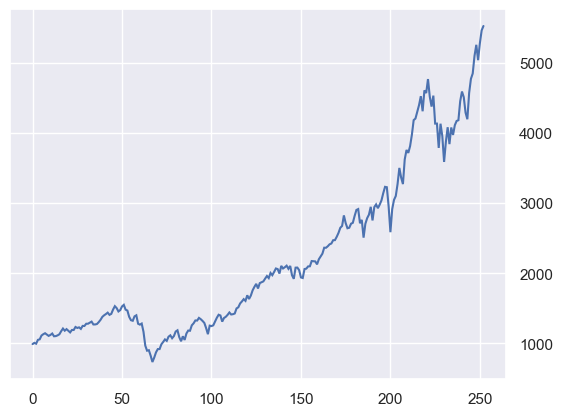

In [19]:
plt.plot(df_spx["Close"].values)

In [20]:
# calculate yoy ratio of SPX from 2004 to 2024 : 
# ratio between year y - 1 and year y 
# => ratio  = (SPX(y) -  SPX(y-1)/ SPX(y-1) for each month
arr_spx_diff = (df_spx["Close"].values[12:]-df_spx["Close"].values[:-12]) / df_spx["Close"].values[:-12]

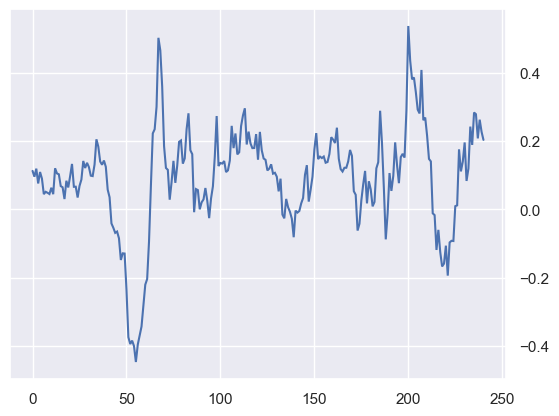

In [21]:
plt.plot(arr_spx_diff)

In [22]:
# add arr_spx_diff to df
df["SPX_diff"] = arr_spx_diff
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969


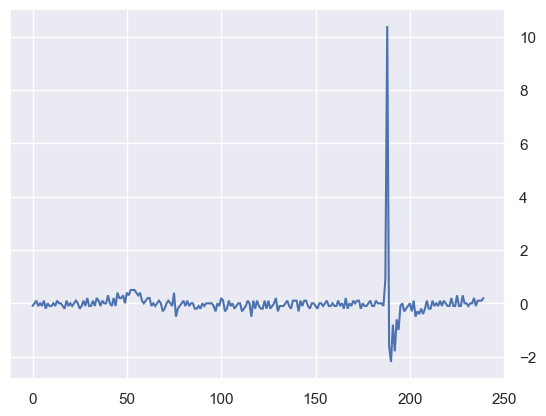

In [24]:
plt.plot(np.diff(df["Total"]))

In [41]:
# calculate next month diff in unemployment rate 
df["Total_diff"] = np.diff(df["Total"], append=np.nan)
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff,Total_diff
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500,-0.1
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465,0.0
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090,0.1
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654,-0.1
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645,0.1
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750,0.1
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613,0.1
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969,0.2


In [45]:
ur_lower = df["Total_diff"] < 0
ur_higher = df["Total_diff"] > 0
ur_stable = df["Total_diff"] == 0
# add ur to df
df["ur_lower"] = ur_lower
df["ur_higher"] = ur_higher
df["ur_stable"] = ur_stable
df

,Month,Total,"Men, 20 years and over","Women, 20 years and over",16 to 19 years old,White,Black or African American,Asian,Hispanic or Latino,Inflation,FEDFUNDS,SPX_diff,Total_diff,ur_lower,ur_higher,ur_stable
0,July 2004,5.5,5.0,4.8,17.8,4.7,11.0,3.9,6.8,3.0,1.26,0.112500,-0.1,True,False,False
1,Aug 2004,5.4,5.0,4.7,16.7,4.7,10.5,3.7,6.8,2.7,1.43,0.095465,0.0,False,False,True
2,Sept 2004,5.4,5.0,4.6,16.6,4.6,10.3,4.5,6.8,2.5,1.61,0.119090,0.1,False,True,False
3,Oct 2004,5.5,4.9,4.7,17.4,4.6,10.8,4.9,6.8,3.2,1.76,0.075654,-0.1,True,False,False
4,Nov 2004,5.4,4.9,4.7,16.4,4.6,10.7,4.1,6.7,3.5,1.93,0.109261,0.0,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,Mar 2024,3.8,3.3,3.6,12.6,3.4,6.4,2.5,4.5,3.5,5.33,0.278645,0.1,False,True,False
237,Apr 2024,3.9,3.6,3.5,11.7,3.5,5.6,2.8,4.8,3.4,5.33,0.207750,0.1,False,True,False
238,May 2024,4.0,3.8,3.4,12.3,3.5,6.1,3.1,5.0,3.3,5.33,0.262613,0.1,False,True,False
239,June 2024,4.1,3.8,3.7,12.1,3.5,6.3,4.1,4.9,3.0,5.33,0.226969,0.2,False,True,False


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

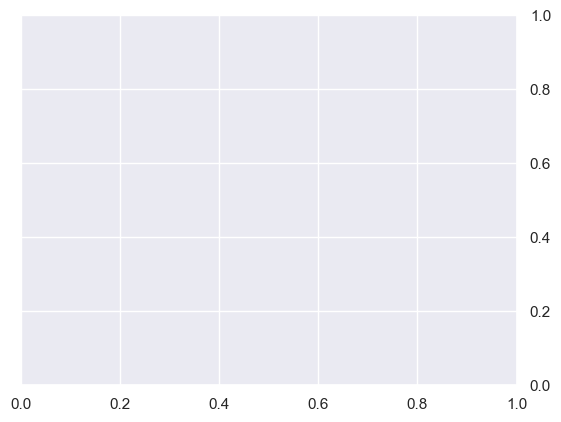

In [30]:
sns.boxplot(x=np.diff(df["Total"]) < 0)